# Finetuning RT_DTR
> Finetuning RT_DTR on the target dataset.

In [2]:
#| default_exp rt_detr.finetuning

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

Notebook is copied from [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/RT-DETR/Fine_tune_RT_DETR_on_a_custom_dataset.ipynb)

In [4]:
#| export
from fastcore.imports import *
from PIL import Image, ImageDraw
from typing import Any, Dict, List, Optional, Tuple, Union
import albumentations as A
import numpy as np
from dataclasses import dataclass


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [5]:
#| export
import torch
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [6]:
#| export
from transformers import AutoImageProcessor
from transformers.image_transforms import center_to_corners_format
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer

from datasets import load_dataset 
from datasets import DatasetDict

2024-07-07 22:07:06.368616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 22:07:06.368695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 22:07:06.368730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 22:07:06.380906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:datasets:PyTorch version 2.

/home/user/miniconda3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [7]:

dataset = load_dataset("cppe-5")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [9]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
IMAGE_SIZE= 480

image_processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)


In [10]:
#| export
def create_val_dataset(
        dataset:DatasetDict,
        test_size:float=0.1):

    if 'validation' not in dataset:
        split = dataset["train"].train_test_split(test_size=test_size, seed=1137)
        dataset['train'] = split['train']
        dataset['validation'] = split['test']


    return dataset

In [11]:
nw_dataset = create_val_dataset(dataset)

In [12]:
nw_dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 900
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 100
    })
})

In [13]:
categories = nw_dataset['train'].features['objects'].feature['category'].names
categories

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

In [14]:
#| export
def idx_categories(
        categories)->Tuple[Dict[int,str],Dict[str,int]]:
    'create id2label and label2id dictionaries'
    id2label = {i:cat for i,cat in enumerate(categories)}
    lbl2id = {cat:i for i,cat in enumerate(categories)}
    return id2label,lbl2id

In [15]:
id2label,lbl2id = idx_categories(categories)
print(id2label, lbl2id)

{0: 'Coverall', 1: 'Face_Shield', 2: 'Gloves', 3: 'Goggles', 4: 'Mask'} {'Coverall': 0, 'Face_Shield': 1, 'Gloves': 2, 'Goggles': 3, 'Mask': 4}


In [16]:
#| export
def get_ds_obj(
        ds:DatasetDict, 
        split:str,
        idx:int=0
        ):
    img = ds[split][idx]['image']
    bbox = ds[split][idx]['objects']

    return img, bbox

In [17]:
#| export
def show_bbox(
        img:Image.Image, # Pil Image
        bbox:List[List[float]], # bounding box lists
        categories:List[int], # categories like [0,1,2,3,4]
        id2label:Dict[int,str] # id to label dictionary
        ):
    draw = ImageDraw.Draw(img)
    for box, cat in zip(bbox, categories):
        x, y, w, h = box
        draw.rectangle((x, y, x+w, y+h), outline='yellow', width=2)
        draw.text((x, y), id2label[cat], fill='yellow')
    return img

In [18]:
img, labels = get_ds_obj(nw_dataset, 'train', 0)

In [19]:
bbox, cats = labels['bbox'], labels['category']
cats

[4, 1, 2, 2, 0]

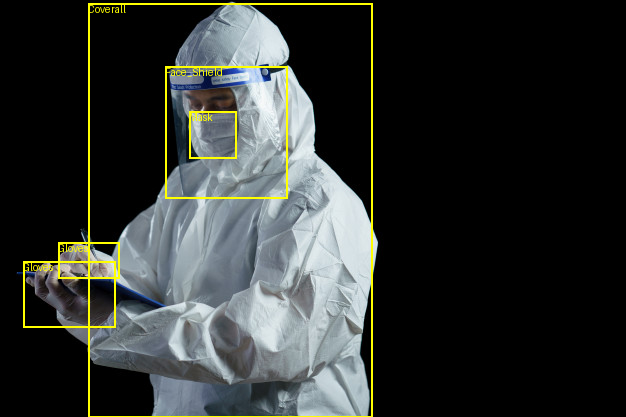

In [20]:
show_bbox(img, bbox, cats, id2label)

## Create Dataset

In [21]:
#| export
class DetectionDataset(Dataset):
    def __init__(
            self, 
            dataset:DatasetDict, 
            id2label:Dict[int,str], 
            lbl2id:Dict[str,int], 
            image_processor:Optional[Any]=None,
            transforms=None):
        self.dataset = dataset
        self.id2label = id2label
        self.lbl2id = lbl2id
        self.image_processor = image_processor
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        image_id = self.dataset[idx]['image_id']

        labels = self.dataset[idx]['objects']
        bbox, cats = labels['bbox'], labels['category']
        img = np.array(img.convert('RGB'))
        if self.transforms:
            transformed = self.transforms(
                image=img,
                bboxes=bbox,
                category=cats)

            img = transformed['image']
            bbox = transformed['bboxes'] 
            cats = transformed['category']

        def format_as_coco(
                img_id:int, 
                categories:List[str],
                boxes:List[List[float]])->Dict[str,Any]:
            'format as coco dataset'

            annotations=[{'image_id':img_id, 'category_id':cate, 'bbox':list(box),'iscrowd':0, 'area':box[2]*box[3]}for cate, box in zip(categories, boxes)]
            return {'image_id':img_id, 'annotations':annotations}

        formatted_ann = format_as_coco(
            img_id=image_id, 
            categories=cats,
            boxes=bbox)

        result = self.image_processor(
            images=img, 
            annotations=formatted_ann,
            return_tensors="pt")

        # Remove batch dimension as image proecessor adds it
        result= {k: v[0] for k, v in result.items() }
        return result



### define augmentations

In [22]:
train_aug = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
                            format="coco", 
                            label_fields=["category"], 
                            clip=True, 
                            min_area=25
                            ),
)
# less than 1 area is removed in case of bbox
val_aug = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=1),
)

In [23]:
train_ds = DetectionDataset(
    dataset=nw_dataset['train'], 
    id2label=id2label, 
    lbl2id=lbl2id, 
    image_processor=image_processor,
    transforms=train_aug)

val_ds = DetectionDataset(
    dataset=nw_dataset['validation'], 
    id2label=id2label, 
    lbl2id=lbl2id, 
    image_processor=image_processor,
    transforms=val_aug)

tst_ds = DetectionDataset(
    dataset=nw_dataset['test'], 
    id2label=id2label, 
    lbl2id=lbl2id, 
    image_processor=image_processor,
    transforms=val_aug)

In [24]:
#| hide
train_ds[0]['pixel_values'].shape,val_ds[0]['pixel_values'].shape,tst_ds[0]['pixel_values'].shape

(torch.Size([3, 480, 480]),
 torch.Size([3, 480, 480]),
 torch.Size([3, 480, 480]))

In [25]:
#| export
def collate_fn(batch):
    data={}
    data['pixel_values'] = torch.stack([item['pixel_values'] for item in batch])
    data['labels'] = [item['labels'] for item in batch]
    return data

## Prepare for Training

## Model creation

In [26]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=lbl2id,
    anchor_image_size=None,
	ignore_mismatched_sizes=True)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.

In [27]:
## Traning Arguments  

In [28]:
training_args = TrainingArguments(
    output_dir="./output",
	num_train_epochs=2,
	max_grad_norm=0.1,
	learning_rate=1e-5,
	warmup_steps=300,
	per_device_train_batch_size=8,
	dataloader_num_workers=4,
	metric_for_best_model="eval_map",
	greater_is_better=True,
	load_best_model_at_end=True,
	eval_strategy="epoch",
	save_strategy="epoch",
	save_total_limit=2,
	remove_unused_columns=False, # wo unused columns no pixel values
	eval_do_concat_batches=False, # to get proper eval res, images have diff number bbox, if concat then it will be wrong
)

### Create metrics during training

In [29]:
id2label

{0: 'Coverall', 1: 'Face_Shield', 2: 'Gloves', 3: 'Goggles', 4: 'Mask'}

In [30]:
def yolo_to_pascal_voc(
	boxes:List[List[float]],
    img:np.ndarray
	)->List[List[float]]:
	'convert yolo format to pascal voc format'
	boxes = center_to_corners_format(boxes)
	h, w = img.shape[:2]
	boxes = torch.Tensor([[w, h, w, h]])
	return boxes


In [31]:
@dataclass
class modelOutput():
	logits:torch.Tensor
	pred_boxes:torch.Tensor


In [32]:

class MAPEvaluator:
	def __init__(
			self,
			image_processor:AutoImageProcessor,
			threshold:float=0.01,
			id2label:Dict[int,str]=id2label):

		self.image_processor=image_processor
		self.thrshold=threshold
		self.id2label=id2label

	def get_image_size(
			self, 
			targets
			)->List[torch.Tensor]:
		image_sizes = []
		for batch in targets:
			b_img_sz = torch.tensor(np.array([x['size'] for x in batch]))
			image_sizes.append(b_img_sz)
		return image_sizes

	def process_targets(
			self, 
			targets:Dict[str,torch.Tensor],
			image_size:List[torch.Tensor],
			)->List[Dict[str,Any]]:
		pr_target=[]
		for b_target, b_img_sz in zip(targets, image_size):
			for target, img_sz in zip(b_target, b_img_sz):
				boxes = torch.tensor(target['boxes'])
				boxes = yolo_to_pascal_voc(boxes, img_sz) 
				labels = torch.tensor(target['class_labels'])
				pr_target.append({'boxes':boxes, 'labels':labels})
		return pr_target

	def process_preds(
			self,
			preds,
			image_sz
	    ):
		pr_preds=[]

		for batch, target_sizes in zip(
										preds, 
										image_sz
										):
			batch_logits, batch_boxes = batch[1], batch[2]
			output = modelOutput(
				logits=batch_logits, 
				pred_boxes=batch_boxes)
			post_pr_output = self.image_processor.post_process_object_detection(
				output, 
				threshold=self.thrshold,
				target_sizes=target_sizes)
			pr_preds.extend(post_pr_output)
		return pr_preds

	@torch.no_grad()
	def __call__(self, eval_res):
		preds, targets = eval_res.predictions, eval_res.label_ids
		image_sz=self.get_image_size(targets)
		pr_targets = self.process_targets(targets, image_sz)
		pr_preds = self.process_preds(preds, image_sz)

		evaluator = MeanAveragePrecision(
			box_format="xyxy",
			class_metrics=True)
		evaluator.warn_on_many_detections = False
		evaluator.update(pr_preds, pr_targets)
		metrics = evaluator.compute()

		# Replace list of per class metrics with separate metric for each class
		classes= metrics.pop('classes')
		map_per_class = metrics.pop('map_per_class')
		map_100_per_class = metrics.pop('map_100_per_class')	
		for class_id, class_map, class_mar in zip(
												classes, 
												map_per_class, 
												map_100_per_class
												):
			class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
			metrics[f"map_{class_name}"] = class_map
			metrics[f"mar_100_{class_name}"] = class_mar

		metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

		return metrics

first we will convert bbox to yolo to pascal_voc format

In [33]:
eval_compute_metrics_fn = MAPEvaluator(
    image_processor=image_processor, 
    threshold=0.01, 
    id2label=id2label)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)
trainer.train()

  0%|          | 0/226 [00:00<?, ?it/s]

In [ ]:
#| hide
import nbdev
nbdev.nbdev_export('02_rt_detr.finetuning.ipynb')